In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (10,6)
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster")
import ipywidgets
import yt

import glob
import os
import warnings
import h5py

import numpy as np
import pandas as pd

from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    get_snapshot_filenames, \
    snapshot_filename_to_number, \
    total_mass_of_snapshot, \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    total_kinetic_energy_of_snapshot, \
    total_internal_energy_of_snapshot, \
    load_snapshots, \
    plot_projected_density, \
    plot_sliced_field, \
    plot_phase_diagram, \
    field_type, \
    plot_profile, \
    yt_plot_saver, \
    mpl_plot_saver

import MHD
    
from sql_helpers import add_simulation, \
    open_as_DataFrame

@yt.derived_field(name="pressure", units="g  / s**2 / cm", sampling_type="particle")
def _pressure(field, data):
    return (gamma-1) * data["thermal_energy"] * data["density"]


# %load_ext autoreload
# %autoreload 2

In [2]:
# run_name = "cluster"
# run_name = "cluster_cooling"
# run_name = "cluster_cooling_100"
# run_name = "cluster_cooling_150"
# run_name = "cluster_cooling_200"
run_name = "cluster_cooling_mhd_200"
# run_name = "cluster_cooling_mhd_small_200"
# run_name = "cluster_cooling_mhd_large_200"
# run_name = "cluster_cooling_250"
# run_name = "cluster_cooling_300"
# run_name = "cluster_cooling_400"
# run_name = "cluster_cooling_small_300"
# run_name = "cluster_cooling_600"
# run_name = "single"
# run_name = "single_cooling"
# run_name = "double"
# run_name = "double_cooling"

run_dir = os.path.join(os.path.pardir, "runs", run_name)

inputs_dir  = os.path.join(run_dir, "inputs")
outputs_dir = os.path.join(run_dir, "outputs")

plots_dir = os.path.join(outputs_dir, "plots")
if not os.path.exists(plots_dir):
    print("making plots_dir")
    os.mkdir(plots_dir)

In [3]:
save_plots = True

# Warning
This file is very much a work-in-progress.

To do:
 - implement a shock-finder
 - only get energy within the remnant

# Update / Load Database

In [4]:
add_simulation(run_name, verbose=False)

df = open_as_DataFrame(run_name)
df.tail()

,number,time,e_kin,e_int,e_mag,mass,momentum,run_name
64,64,17.118857,1.064779e+50,6.198384e+50,0.0,7.097495e+06,3.160041e+44,cluster_cooling_mhd_200
65,65,17.620927,9.888033e+49,5.552011e+50,0.0,7.097495e+06,3.100250e+44,cluster_cooling_mhd_200
66,66,18.122997,9.597881e+49,5.245573e+50,0.0,7.097495e+06,3.019993e+44,cluster_cooling_mhd_200
67,67,18.625068,9.439040e+49,5.068611e+50,0.0,7.097495e+06,2.931606e+44,cluster_cooling_mhd_200
68,68,19.127138,9.258508e+49,4.974902e+50,0.0,7.097495e+06,2.839616e+44,cluster_cooling_mhd_200


In [5]:
df

,number,time,e_kin,e_int,e_mag,mass,momentum,run_name
0,0,0.000000,0.000000e+00,1.433358e+52,0.0,7.097382e+06,0.000000e+00,cluster_cooling_mhd_200
1,1,0.001000,0.000000e+00,1.533358e+52,0.0,7.097388e+06,0.000000e+00,cluster_cooling_mhd_200
2,2,0.127017,1.306865e+50,2.778505e+51,0.0,7.097388e+06,4.305873e+43,cluster_cooling_mhd_200
3,3,0.253034,7.239810e+49,5.359074e+50,0.0,7.097388e+06,4.440986e+43,cluster_cooling_mhd_200
4,4,0.379051,5.148759e+49,5.221385e+50,0.0,7.097388e+06,4.499257e+43,cluster_cooling_mhd_200
5,5,0.505068,4.042894e+49,5.154919e+50,0.0,7.097388e+06,4.523959e+43,cluster_cooling_mhd_200
6,6,0.631085,3.344486e+49,5.108519e+50,0.0,7.097388e+06,4.526851e+43,cluster_cooling_mhd_200
7,7,0.633085,3.344486e+49,1.510852e+51,0.0,7.097403e+06,4.526851e+43,cluster_cooling_mhd_200
8,8,1.014899,8.349971e+49,6.303834e+50,0.0,7.097403e+06,8.673679e+43,cluster_cooling_mhd_200
9,9,1.396712,6.103829e+49,5.417609e+50,0.0,7.097403e+06,9.136334e+43,cluster_cooling_mhd_200


# Overview

In [6]:
SNe = get_SNe(inputs_dir)
SN_times           = np.array([SN.time          for SN in SNe])
SN_ejecta_masses   = np.array([SN.ejecta_mass   for SN in SNe])
SN_ejecta_masses_Z = np.array([SN.ejecta_mass_Z for SN in SNe])

In [7]:
print(SN_times)

[  0.           0.63208546   2.54315284   3.14359457   3.86827896
   7.49870396   7.79650861  13.99268639  16.11371587  27.16126385
  28.58597612]


In [8]:
print(SN_ejecta_masses)

[  6.65532996  15.07930637  15.19322279  15.63180503  15.80695932
  12.64808195  12.3961955   10.41067938   9.71941612   7.377793
   7.17954564]


In [9]:
df.time

0      0.000000
1      0.001000
2      0.127017
3      0.253034
4      0.379051
5      0.505068
6      0.631085
7      0.633085
8      1.014899
9      1.396712
10     1.778526
11     2.160339
12     2.542153
13     2.544153
14     2.663841
15     2.783530
16     2.903218
17     3.022906
18     3.142595
19     3.144595
20     3.289131
21     3.433668
22     3.578205
23     3.722742
24     3.867279
25     3.867279
26     3.869279
27     4.387625
28     4.905972
29     5.424318
        ...    
39     7.736348
40     7.795509
41     7.795509
42     7.797509
43     8.313690
44     8.829872
45     9.346053
46     9.862235
47    10.378416
48    10.894597
49    11.410779
50    11.926960
51    12.443142
52    12.959323
53    13.475505
54    13.991686
55    13.993686
56    14.417492
57    14.841298
58    15.265104
59    15.688910
60    16.112716
61    16.112716
62    16.114716
63    16.616786
64    17.118857
65    17.620927
66    18.122997
67    18.625068
68    19.127138
Name: time, Length: 69, 

In [10]:
ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))

times_snapshots = df.time

print("Loaded {} uncompressed snapshots".format(len(ts)))

ds = ts[0]
rho_0 = ds.all_data()["all","density"].mean()


Loaded 10 uncompressed snapshots


yt : [INFO     ] 2017-10-12 11:43:02,911 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2017-10-12 11:43:02,934 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-12 11:43:02,935 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-10-12 11:43:02,936 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-10-12 11:43:02,937 Parameters: domain_right_edge         = [ 600.  600.  600.]
yt : [INFO     ] 2017-10-12 11:43:02,939 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2017-10-12 11:43:02,945 Allocating for 2.700e+07 particles (index particle type 'all')
yt : [INFO     ] 2017-10-12 11:43:07,710 Identified 2.364e+06 octs


In [11]:
times_snapshots

0      0.000000
1      0.001000
2      0.127017
3      0.253034
4      0.379051
5      0.505068
6      0.631085
7      0.633085
8      1.014899
9      1.396712
10     1.778526
11     2.160339
12     2.542153
13     2.544153
14     2.663841
15     2.783530
16     2.903218
17     3.022906
18     3.142595
19     3.144595
20     3.289131
21     3.433668
22     3.578205
23     3.722742
24     3.867279
25     3.867279
26     3.869279
27     4.387625
28     4.905972
29     5.424318
        ...    
39     7.736348
40     7.795509
41     7.795509
42     7.797509
43     8.313690
44     8.829872
45     9.346053
46     9.862235
47    10.378416
48    10.894597
49    11.410779
50    11.926960
51    12.443142
52    12.959323
53    13.475505
54    13.991686
55    13.993686
56    14.417492
57    14.841298
58    15.265104
59    15.688910
60    16.112716
61    16.112716
62    16.114716
63    16.616786
64    17.118857
65    17.620927
66    18.122997
67    18.625068
68    19.127138
Name: time, Length: 69, 

In [12]:
SN_ejecta_masses

array([  6.65532996,  15.07930637,  15.19322279,  15.63180503,
        15.80695932,  12.64808195,  12.3961955 ,  10.41067938,
         9.71941612,   7.377793  ,   7.17954564])

In [13]:
print( "Length unit: ",   ds.length_unit)
print( "Time unit: ",     ds.time_unit)
print( "Mass unit: ",     ds.mass_unit)
print( "Velocity unit: ", ds.velocity_unit)

Length unit:  0.001000000000163616 kpc
Time unit:  31557600000000.0 s
Mass unit:  1.0000299511482191 Msun
Velocity unit:  97779.22216731282 cm/s


In [14]:
# ds = ts[0]
# dd = ds.all_data()
# initial_temperature = np.median(dd[("PartType0", "Temperature")])
# del dd

# initial_temperature

# What fields do I have access to?

In [15]:
ds = ts[-1]
dd = ds.all_data()

yt : [INFO     ] 2017-10-12 11:43:13,489 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2017-10-12 11:43:13,505 Parameters: current_time              = 19.127138034
yt : [INFO     ] 2017-10-12 11:43:13,506 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-10-12 11:43:13,507 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-10-12 11:43:13,508 Parameters: domain_right_edge         = [ 600.  600.  600.]
yt : [INFO     ] 2017-10-12 11:43:13,509 Parameters: cosmological_simulation   = 0


In [16]:
ds.field_list

yt : [INFO     ] 2017-10-12 11:43:13,520 Allocating for 2.700e+07 particles (index particle type 'all')
yt : [INFO     ] 2017-10-12 11:43:17,725 Identified 2.332e+06 octs


[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'DivBcleaningFunctionGradPhi'),
 ('PartType0', 'DivBcleaningFunctionPhi'),
 ('PartType0', 'DivergenceOfMagneticField'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'MagneticField'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity'),
 ('PartType0', 'NeutralHydrogenAbundance'),
 ('PartType0', 'ParticleChildIDsNumber'),
 ('PartType0', 'ParticleIDGenerationNumber'),
 ('PartType0', 'ParticleIDs'),
 ('PartType0', 'SmoothingLength'),
 ('PartType0', 'Velocities'),
 ('all', 'Coordinates'),
 ('all', 'Density'),
 ('all', 'DivBcleaningFunctionGradPhi'),
 ('all', 'DivBcleaningFunctionPhi'),
 ('all', 'DivergenceOfMagneticField'),
 ('all', 'ElectronAbundance'),
 ('all', 'InternalEnergy'),
 ('all', 'MagneticField'),
 ('all', 'Masses'),
 ('all', 'Metallicity'),
 ('all', 'NeutralHydrogenAbundance'),
 ('all', 'ParticleChildIDsNumber'),
 ('all', 'ParticleIDGenerationNumber'),
 ('all', '

In [17]:
ds.derived_field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'DivBcleaningFunctionGradPhi'),
 ('PartType0', 'DivBcleaningFunctionPhi'),
 ('PartType0', 'DivergenceOfMagneticField'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'H_nuclei_density'),
 ('PartType0', 'He_nuclei_density'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'MagneticField'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity'),
 ('PartType0', 'NeutralHydrogenAbundance'),
 ('PartType0', 'ParticleChildIDsNumber'),
 ('PartType0', 'ParticleIDGenerationNumber'),
 ('PartType0', 'ParticleIDs'),
 ('PartType0', 'SmoothingLength'),
 ('PartType0', 'Temperature'),
 ('PartType0', 'Velocities'),
 ('PartType0', 'density'),
 ('PartType0', 'mesh_id'),
 ('PartType0', 'metallicity'),
 ('PartType0', 'particle_angular_momentum'),
 ('PartType0', 'particle_angular_momentum_magnitude'),
 ('PartType0', 'particle_angular_momentum_x'),
 ('PartType0', 'particle_angular_momentum_y'),
 ('PartType0', 'particle_angular_mo

# Plot Summary Quantities

In [18]:
energies = np.loadtxt(os.path.join(outputs_dir, "energy.txt"), ndmin=2)

times_statistics    = energies[:,0] * ds.time_unit
thermal_energies    = energies[:,1] * ds.mass_unit * (ds.velocity_unit)**2
potential_energies  = energies[:,2] * ds.mass_unit * (ds.velocity_unit)**2
kinetic_energies    = energies[:,3] * ds.mass_unit * (ds.velocity_unit)**2

times_statistics    = times_statistics.convert_to_cgs().value / Myr
thermal_energies    = thermal_energies.convert_to_cgs().value
potential_energies  = potential_energies.convert_to_cgs().value
kinetic_energies    = kinetic_energies.convert_to_cgs().value


total_mass    = energies[:,-6]


total_energies = thermal_energies + kinetic_energies

sorted_times_statistics_indices = np.argsort(times_statistics)

In [19]:
_e_kin = df.e_kin
_e_int = df.e_int
_e_tot = _e_kin + _e_int

Plotting:  E_kin in ../runs/cluster_cooling_mhd_200/outputs/plots


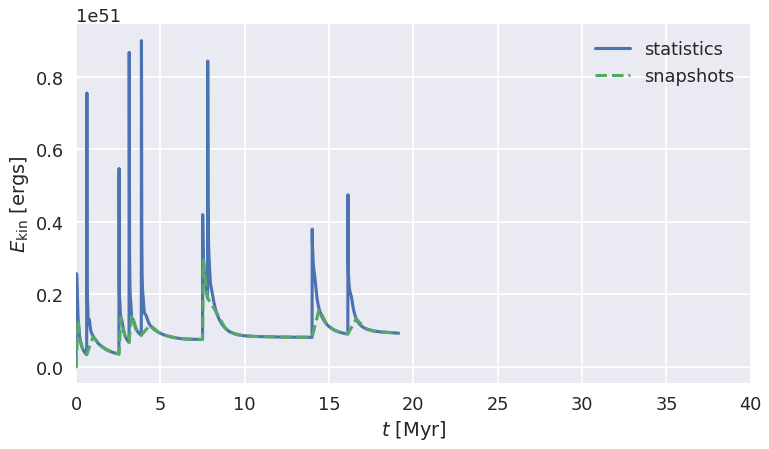

In [20]:
# sns.rugplot(SN_times, color="k", linewidth=3)
plt.plot(times_statistics[sorted_times_statistics_indices],
         kinetic_energies[sorted_times_statistics_indices],
         label="statistics")
plt.plot(times_snapshots, _e_kin, label="snapshots", linestyle="dashed")
plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
plt.ylabel(r"$E_\mathrm{kin}$ $[\mathrm{ergs}]$")
plt.legend(loc="best")

plt.xlim(0,40)

plot_name = "E_kin"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

In [21]:
thermal_energies

array([  1.43290749e+52,   1.53287609e+52,   1.53287524e+52, ...,
         4.97523714e+50,   4.97426756e+50,   4.97333600e+50])

Plotting:  E_int in ../runs/cluster_cooling_mhd_200/outputs/plots


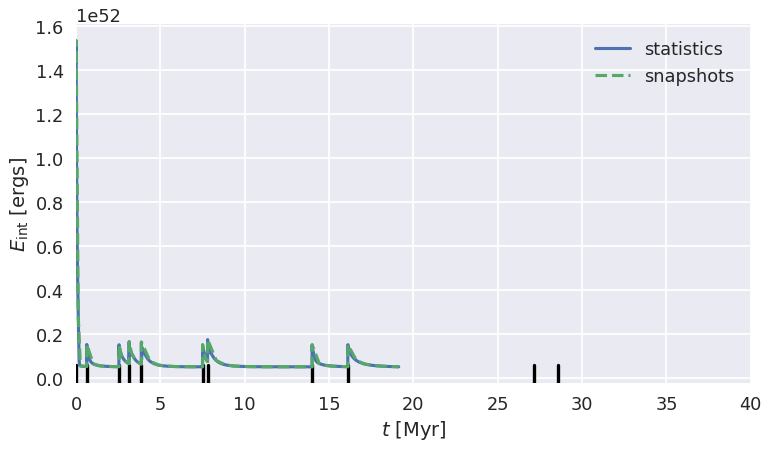

In [22]:
sns.rugplot(SN_times, color="k", linewidth=3)
plt.plot(times_statistics[sorted_times_statistics_indices],
         thermal_energies[sorted_times_statistics_indices],
         label="statistics",
        )
plt.plot(times_snapshots, _e_int, label="snapshots", linestyle="dashed")
plt.legend(loc="best")
plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
plt.ylabel(r"$E_\mathrm{int}$ $[\mathrm{ergs}]$")

plt.xlim(0,40)

plot_name = "E_int"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

Plotting:  E_tot in ../runs/cluster_cooling_mhd_200/outputs/plots


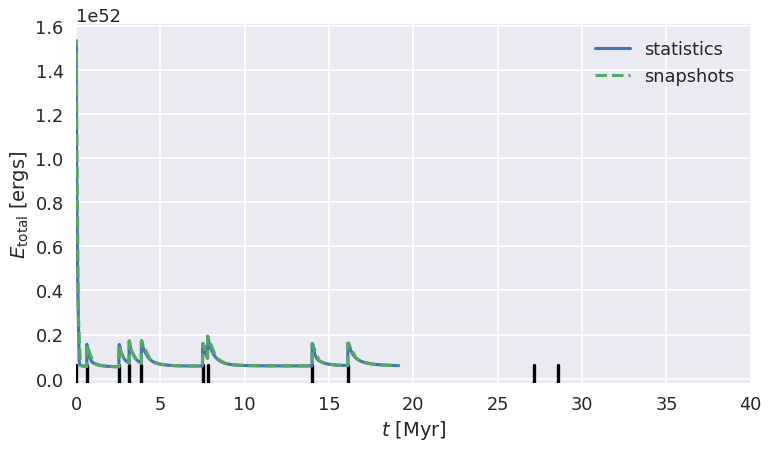

In [23]:
sns.rugplot(SN_times, color="k", linewidth=3)
plt.plot(times_statistics[sorted_times_statistics_indices],
         total_energies[sorted_times_statistics_indices],
         label="statistics")
plt.plot(times_snapshots, _e_tot, label="snapshots", linestyle="dashed")
plt.legend(loc="best")
plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
plt.ylabel(r"$E_\mathrm{total}$ $[\mathrm{ergs}]$")

plt.xlim(0,40)

plot_name = "E_tot"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

To do: remove the contribution from cooling outside the remnant

Plotting:  E_tot_delta in ../runs/cluster_cooling_mhd_200/outputs/plots


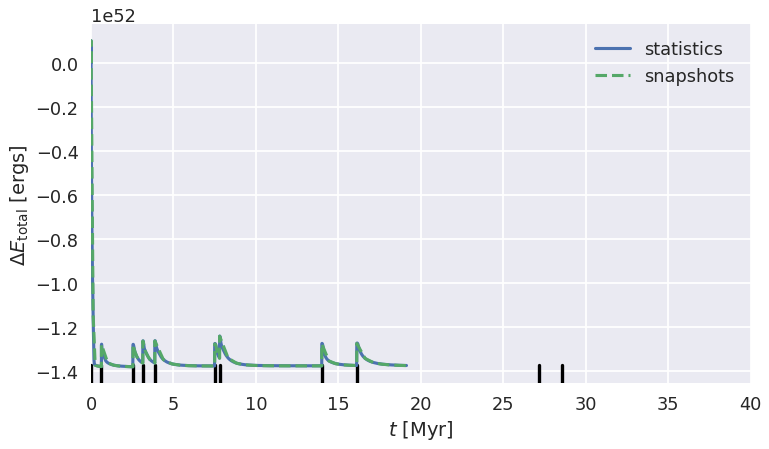

In [24]:
sns.rugplot(SN_times, color="k", linewidth=3)
plt.plot(times_statistics[sorted_times_statistics_indices], 
         total_energies[sorted_times_statistics_indices] - total_energies[sorted_times_statistics_indices][0],
         label="statistics")
plt.plot(times_snapshots, _e_tot - _e_tot[0], label="snapshots", linestyle="dashed")
plt.legend(loc="best")
plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
plt.ylabel(r"$\Delta E_\mathrm{total}$ $[\mathrm{ergs}]$")

plt.xlim(0,40)

plot_name = "E_tot_delta"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

In [25]:
print((total_energies - total_energies[0]) / 1e51)

[  0.           0.999686     0.9996775  ..., -13.73890768 -13.73905045
 -13.73918981]


# Plot Timing
Can be useful for noticing if the energy file doubles back on itself

Plotting:  times_snapshots in ../runs/cluster_cooling_mhd_200/outputs/plots


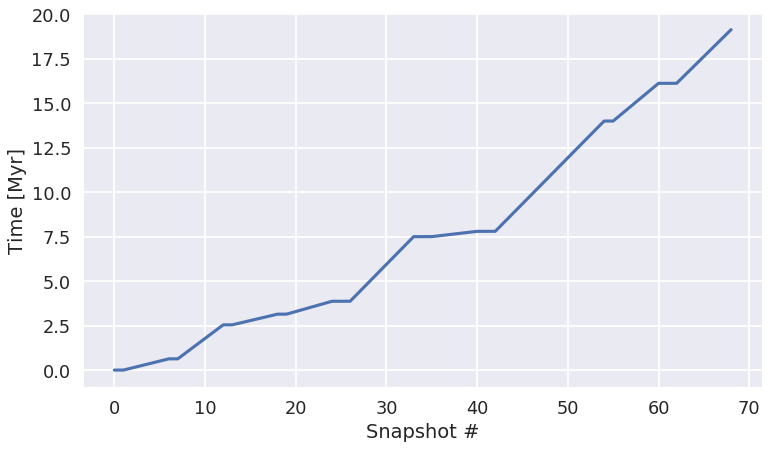

In [26]:
plt.plot(times_snapshots)
plt.xlabel("Snapshot #")
plt.ylabel("Time [Myr]")

plot_name = "times_snapshots"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

Plotting:  times_statistics in ../runs/cluster_cooling_mhd_200/outputs/plots


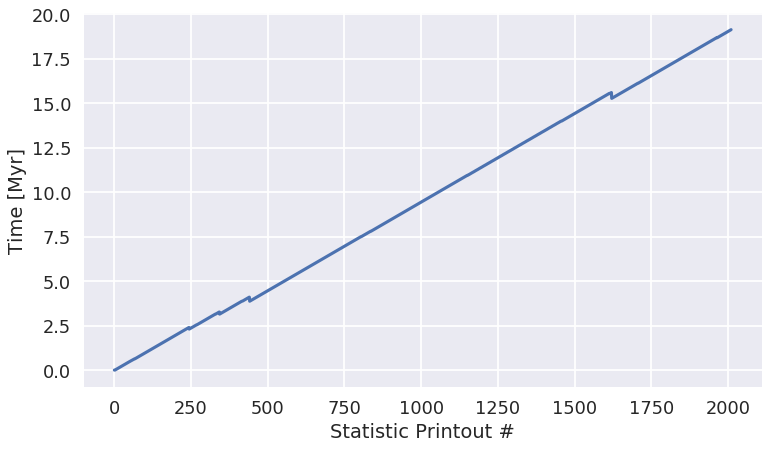

In [27]:
plt.plot(times_statistics)
plt.xlabel("Statistic Printout #")
plt.ylabel("Time [Myr]")

plot_name = "times_statistics"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

## Mass Plots

WARNING: in "energy.txt" GIZMO only uses %g formatting; the change in total mass due to ejecta might be truncated 

In [28]:
masses = df.mass

Plotting:  mass in ../runs/cluster_cooling_mhd_200/outputs/plots


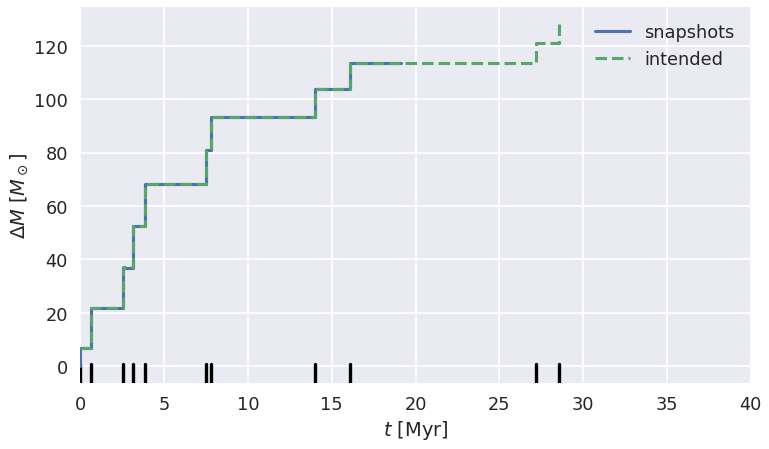

In [29]:
sns.rugplot(SN_times, color="k", linewidth=3)
plt.plot(times_snapshots, masses - masses[0], 
         label="snapshots", linestyle="solid", drawstyle="steps-post")
plt.plot(SN_times, SN_ejecta_masses.cumsum(), 
         label="intended", linestyle="dashed", drawstyle="steps-post")
plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
plt.ylabel(r"$\Delta M$ $[M_\odot]$")
plt.legend(loc="best")

plt.xlim(0,40)

plot_name = "mass"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

## Momentum Plots

In [30]:
radial_momentum = df.momentum

In [31]:
radial_momentum / (100 * M_solar * km / s * SN_times.size)

0        0.000000
1        0.000000
2      196.855844
3      203.032916
4      205.696986
5      206.826311
6      206.958493
7      206.958493
8      396.543132
9      417.694776
10     420.556262
11     417.083359
12     410.953592
13     410.953592
14     553.153446
15     595.380308
16     613.775923
17     628.080755
18     637.579548
19     637.579548
20     744.581419
21     795.715075
22     817.860606
23     833.908443
24     843.575752
25     843.627146
26     843.627146
27    1038.560582
28    1065.587064
29    1061.932425
         ...     
39    1213.299538
40    1222.722539
41    1222.915895
42    1222.915895
43    1410.226428
44    1422.726603
45    1404.225667
46    1375.025796
47    1341.442674
48    1306.255134
49    1270.594139
50    1235.748497
51    1201.462708
52    1166.958001
53    1132.189289
54    1097.274459
55    1097.274459
56    1330.077335
57    1329.399070
58    1307.261371
59    1277.617091
60    1245.335455
61    1245.157813
62    1245.157813
63    1443

Plotting:  momentum_total in ../runs/cluster_cooling_mhd_200/outputs/plots


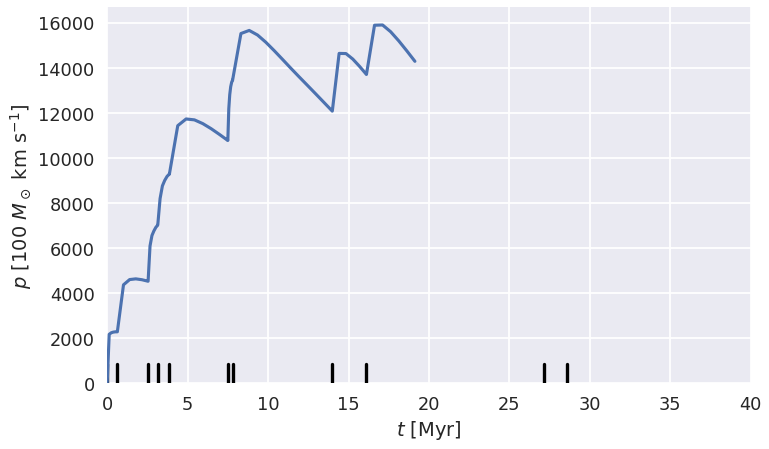

In [32]:
sns.rugplot(SN_times, color="k", linewidth=3)
plt.plot(times_snapshots, radial_momentum / (100 * M_solar * km / s))

plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
plt.ylabel(r"$p$ $[100$ $M_\odot$ $\mathrm{km}$ $\mathrm{s}^{-1}]$")
plt.ylim(ymin=0)

plt.xlim(0,40)

plot_name = "momentum_total"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

Plotting:  momentum_normalized in ../runs/cluster_cooling_mhd_200/outputs/plots


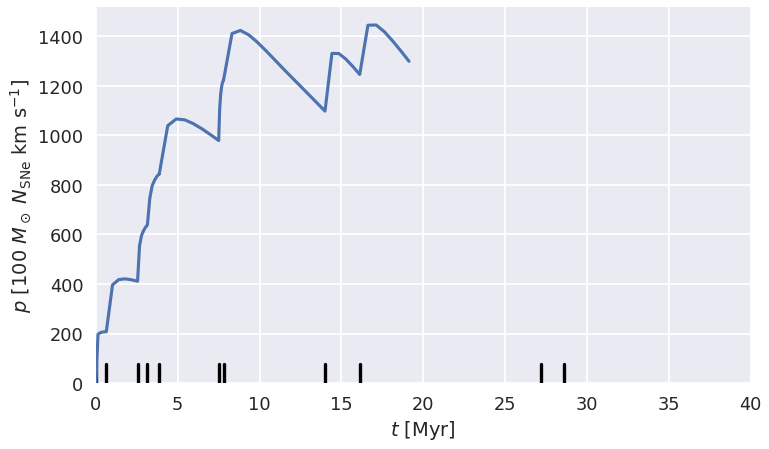

In [33]:
sns.rugplot(SN_times, color="k", linewidth=3)
plt.plot(times_snapshots, radial_momentum / (100 * M_solar * km / s * SN_times.size))
plt.xlabel(r"$t$ $[\mathrm{Myr}]$")
plt.ylabel(r"$p$ $[100$ $M_\odot$ $N_\mathrm{SNe}$ $\mathrm{km}$ $\mathrm{s}^{-1}]$")
plt.ylim(ymin=0)

plt.xlim(0,40)

plot_name = "momentum_normalized"
if save_plots:
    mpl_plot_saver(plt.gcf(), plot_name, plots_dir)

# Plot Snapshot Views

## but first, will I need B-field lines?

yt : [INFO     ] 2017-10-12 11:47:16,233 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2017-10-12 11:47:16,268 Parameters: current_time              = 5.42431823773
yt : [INFO     ] 2017-10-12 11:47:16,270 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-10-12 11:47:16,273 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-10-12 11:47:16,275 Parameters: domain_right_edge         = [ 600.  600.  600.]
yt : [INFO     ] 2017-10-12 11:47:16,278 Parameters: cosmological_simulation   = 0


with MHD


yt : [INFO     ] 2017-10-12 11:47:16,293 Allocating for 2.700e+07 particles (index particle type 'all')
yt : [INFO     ] 2017-10-12 11:47:20,788 Identified 2.337e+06 octs
/pfs/home/egentry/data/gizmo-clustered-SNe/scripts/MHD.py:38: RuntimeWarning: invalid value encountered in greater
  By_Bz[By_Bz > max_value] = np.nan


(400, 400, 3)


/pfs/home/egentry/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


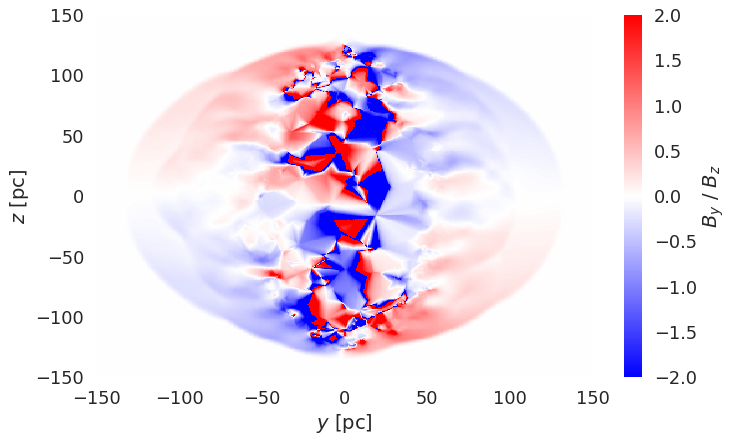

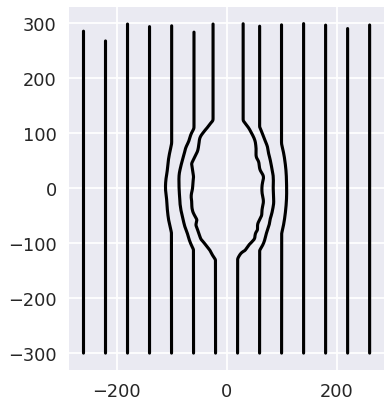

In [38]:
ds = ts[snapshot_number_to_index_map[29]]
if "mhd" in run_name.lower():
    print("with MHD")
    field_line_filename = MHD.get_field_lines_filename_from_ds(ds, plots_dir)
    if not os.path.exists(field_line_filename):
        print("calculating magnetic field lines")
        df_lines = MHD.calculate_magnetic_field_lines(ds, plots_dir)
    else:
        print("field lines already calculated -- not recalculating")

## Projection Plot

In [39]:
ipywidgets.interact(plot_projected_density,
    ts = ipywidgets.fixed(ts),
    snapshot_number = ipywidgets.SelectionSlider(
        options=uncompressed_snapshot_numbers,
        value=uncompressed_snapshot_numbers[-1],
        ),
    snapshot_number_to_index_map = ipywidgets.fixed(snapshot_number_to_index_map),
    SN_times  = ipywidgets.fixed(SN_times),
    plots_dir = ipywidgets.fixed(plots_dir),
    save_plot = ipywidgets.fixed(save_plots),
    show_plot = ipywidgets.fixed(True),
    seaborn_style = ipywidgets.fixed("white"),
)
    
                    

interactive(children=(SelectionSlider(description='snapshot_number', index=9, options=(0, 27, 28, 29, 30, 31, 32, 33, 34, 68), value=68), Output()), _dom_classes=('widget-interact',))

<function visualize_helpers.plot_projected_density>

In [36]:
ipywidgets.interact(plot_sliced_field,
    ts = ipywidgets.fixed(ts),
    snapshot_number = ipywidgets.SelectionSlider(
        options=uncompressed_snapshot_numbers,
        value=uncompressed_snapshot_numbers[-1],
        ),
    snapshot_number_to_index_map = ipywidgets.fixed(snapshot_number_to_index_map),
    field = ipywidgets.Dropdown(options=list(field_type.keys()), value="density"),
    SN_times  = ipywidgets.fixed(SN_times),
    plots_dir = ipywidgets.fixed(plots_dir),
    save_plot = ipywidgets.fixed(save_plots),
    show_plot = ipywidgets.fixed(True),
    seaborn_style = ipywidgets.fixed("white"),
    add_magnetic_field_lines = ipywidgets.fixed("mhd" in run_name.lower()),
)
    

interactive(children=(SelectionSlider(description='snapshot_number', index=9, options=(0, 27, 28, 29, 30, 31, 32, 33, 34, 68), value=68), Dropdown(description='field', options=('density', 'temperature', 'pressure', 'velocity_magnitude', 'radius', 'metallicity'), value='density'), Output()), _dom_classes=('widget-interact',))

<function visualize_helpers.plot_sliced_field>

In [ ]:
ipywidgets.interact(plot_profile,
    ts = ipywidgets.fixed(ts),
    snapshot_number = ipywidgets.SelectionSlider(
        options=uncompressed_snapshot_numbers,
        value=uncompressed_snapshot_numbers[-1],
        ),
    snapshot_number_to_index_map = ipywidgets.fixed(snapshot_number_to_index_map),
    field = ipywidgets.Dropdown(options=list(field_type.keys()), value="density"),
    rho_0     = ipywidgets.fixed(0),
    plots_dir = ipywidgets.fixed(plots_dir),
    save_plot = ipywidgets.fixed(save_plots),
    show_plot = ipywidgets.fixed(True),
)

# Phase Diagram

In [ ]:
# ipywidgets.interact(plot_phase_diagram,
#     ts = ipywidgets.fixed(ts),
#     snapshot_number = ipywidgets.SelectionSlider(
#         options=uncompressed_snapshot_numbers,
#         value=uncompressed_snapshot_numbers[-1],
#         ),
#     snapshot_number_to_index_map=ipywidgets.fixed(snapshot_number_to_index_map),
#     SN_times=ipywidgets.fixed(SN_times),
#     plots_dir=ipywidgets.fixed(plots_dir),
#     save_plot=ipywidgets.fixed(save_plots),
#     show_plot=ipywidgets.fixed(True),
# )